In [1]:
import pandas as pd
import numpy as np
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder 

In [2]:
data_df1 = pd.read_excel('Data_TripAdvisor_v1.xls')
data_df2 = pd.read_csv('/home/jinfeng/Downloads/technique/dataset/context dataset/Travel_TripAdvisor_v2/Data_TripAdvisor_v2.csv')

In [3]:
data_df1.head()

,ID_USER,USER_STATE,USER_TIMEZONE,ID_HOTEL,HOTEL_CITY,HOTEL_STATE,HOTEL_TIMEZONE,Trip Type,Rating
0,45,GA,Eastern,105170,Memphis,TN,Central,3,5
1,45,GA,Eastern,223229,SanAntonio,TX,Central,3,5
2,45,GA,Eastern,258688,Albuquerque,NM,Mountain,3,5
3,45,GA,Eastern,98827,ELPaso,TX,Central,3,5
4,45,GA,Eastern,99518,SanAntonio,TX,Central,3,3


In [4]:
data_df2.head()

,UserID,ItemID,Rating,UserState,UserTimeZone,ItemCity,ItemState,ItemTimeZone,TripType
0,5C28F393B23BB894523AE7126A7AE445,219668,5,AK,AK,GREENSBORO,NC,EASTERN,SOLO
1,3FA27F6E8AC712A82C69C4EDD8B912CC,223860,5,AK,AK,PHOENIX,AZ,MOUNTAIN,SOLO
2,B99CFBB5411EDC8881D13B7A4B313ADA,75680,5,AK,AK,ANAHEIM,CA,PACIFIC,FAMILY
3,3FA27F6E8AC712A82C69C4EDD8B912CC,224783,5,AK,AK,SEATTLE,WA,PACIFIC,SOLO
4,7CEFF5C32BA1F3B186E7838C7D3FE25E,222984,5,AK,AK,MIAMI,MI,EASTERN,COUPLES


In [5]:
data_df2['ItemCity'].value_counts()

NEWYORK         647
LASVEGAS        553
ORLANDO         516
WASHINGTONDC    506
PHILADELPHIA    493
               ... 
FRISCO            6
NAPERVILLE        5
SYRACUSE          4
CHULA VISTA       3
GARLAND           2
Name: ItemCity, Length: 107, dtype: int64

In [6]:
data_df1['ID_USER'].value_counts()

27783    19
40423    16
13087    16
52194    12
14195    12
         ..
11063     3
51983     3
19191     3
730       3
47181     3
Name: ID_USER, Length: 1202, dtype: int64

In [7]:
le = LabelEncoder()
y = le.fit_transform(data_df2['UserID'])
data_df2['UserID'] = y
data_df2.head()

,UserID,ItemID,Rating,UserState,UserTimeZone,ItemCity,ItemState,ItemTimeZone,TripType
0,875,219668,5,AK,AK,GREENSBORO,NC,EASTERN,SOLO
1,609,223860,5,AK,AK,PHOENIX,AZ,MOUNTAIN,SOLO
2,1779,75680,5,AK,AK,ANAHEIM,CA,PACIFIC,FAMILY
3,609,224783,5,AK,AK,SEATTLE,WA,PACIFIC,SOLO
4,1183,222984,5,AK,AK,MIAMI,MI,EASTERN,COUPLES


In [8]:
data_df2['UserID'] = data_df2['UserID'] + 2370

In [9]:
df1 = data_df1[['ID_USER','ID_HOTEL','Rating','Trip Type']]
df1 = df1.rename(columns = {'ID_USER':'userID','ID_HOTEL':'itemID','Rating':'rating','Trip Type':'TripType'})

In [10]:
df2 = data_df2[['UserID','ItemID','Rating','TripType']]
df2 = df2.rename(columns = {'UserID':'userID','ItemID':'itemID','Rating':'rating'})

In [11]:
df2['TripType'].value_counts()

COUPLES     4701
SOLO        2997
FAMILY      2921
BUSINESS    2794
FRIENDS      762
Name: TripType, dtype: int64

In [12]:
df1['TripType'].value_counts()

3    2062
2    1005
1     771
4     635
5     196
Name: TripType, dtype: int64

In [13]:
triptype = {'FAMILY':1,'COUPLES':2,'BUSINESS':3,'SOLO':4,'FRIENDS':5}
df2['TripType'] = df2['TripType'].map(triptype)

In [14]:
frame = [df1,df2]
df_final = pd.concat(frame)

In [15]:
df_final = df_final.reset_index()

In [16]:
del df_final['index']

In [17]:
context_explain = df_final.copy()
context_explain = context_explain.astype('float')
context_explain.iloc[:,3:] = context_explain.iloc[:,3:].astype('object')
context_test_user = pd.get_dummies(context_explain)

In [18]:
def calculate_correlation(context):
    user_context_correlation = dict()
    context_user_correlation = dict()
    item_context_correlation = dict()
    context_item_correlation = dict()
    
    context_test_user = context.copy()

    cluster_set = list(set(context_test_user['userID'].values))
    for cluster in cluster_set:
        user_context_correlation.setdefault(cluster, defaultdict())
        test = context_test_user[context_test_user['userID'] == cluster]
        for context_factor in test.columns[3:]:
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            user_context_correlation[cluster][context_factor] = d2

    for context_factor in context_test_user.columns[3:]:
        context_user_correlation.setdefault(context_factor, defaultdict())
        for cluster in cluster_set:
            test = context_test_user[context_test_user['userID'] == cluster]
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            context_user_correlation[context_factor][cluster] = d2

    cluster_item = list(set(context_test_user['itemID'].values))
    for cluster in cluster_item:
        item_context_correlation.setdefault(cluster, defaultdict())
        test = context_test_user[context_test_user['itemID'] == cluster]
        for context_factor in test.columns[3:]:
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            item_context_correlation[cluster][context_factor] = d2

    for context_factor in context_test_user.columns[3:]:
        context_item_correlation.setdefault(context_factor, defaultdict())
        for cluster in cluster_item:
            test = context_test_user[context_test_user['itemID'] == cluster]
            X = np.vstack([test['rating'].values, test[context_factor].values])
            d2 = np.corrcoef(X)[0][1]
            context_item_correlation[context_factor][cluster] = d2

    
    return user_context_correlation, context_user_correlation, item_context_correlation, context_item_correlation
user_context_correlation, context_user_correlation, item_context_correlation, context_item_correlation = calculate_correlation(context_test_user)

/home/jinfeng/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jinfeng/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/jinfeng/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/jinfeng/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/home/jinfeng/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [19]:
def cosine_similarity(x,y):
    x = np.array(x)
    y = np.array(y)
    where1 = np.isnan(x)
    x[where1] = 0.00001
    where2 = np.isnan(y)
    y[where2] = 0.00001
    num = x.dot(y.T)
    denom = np.linalg.norm(x) * np.linalg.norm(y)
    return num / denom
def cal_similarity_context(x,tg):
    x['sim_context'] = None
    for j in x.index:
        x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])
    return x
def select_local(train_data,i):
    df = train_data.copy()
    context_test_rec = cal_similarity_context(df,i)
    local = context_test_rec[context_test_rec['sim_context'] > 0.5]
    media = local.copy()
    localt = media.drop(index=[i])
    return localt,local
def model_train_for_rec(train_data,i):
    localt,local = select_local(train_data,i)
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(localt[['userID', 'itemID', 'rating']], reader)
    param_grid = {'n_factors': [25, 30, 35, 40],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
    gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    algo = gs.best_estimator['rmse']
    algo.fit(data.build_full_trainset())
    return algo,localt,local

In [20]:
test_try = context_explain.copy()
test_try.iloc[:,3:] = test_try.iloc[:,3:].astype('object')
test_try = pd.get_dummies(test_try)
test_try['context_vector'] = None

for i in test_try.index:
    cluster = test_try['userID'][i]
    test_try['context_vector'][i] = []
    for c in test_try.columns[3:]:
        if test_try[c][i] == 1:
            test_try['context_vector'][i].append(user_context_correlation[cluster][c])


<ipython-input-20-760d607483d7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_try['context_vector'][i] = []


In [21]:
def recommend_all(x):
  res = []
  for items in x:
    items  = np.insert(items,2,1) 
    usadata = items
    context = context_explain.copy()

    context.loc[-1] = usadata
    context.iloc[:,3:] = context.iloc[:,3:].astype('object')
    context = pd.get_dummies(context)
    context['context_vector'] = None
    cluster = context['userID'][-1]
    context['context_vector'][-1] = []
    for c in context.columns[3:]:
        if context[c][-1] == 1:
            context['context_vector'][-1].append(user_context_correlation[cluster][c])
    rec_mid = test_try.copy()
    rec_mid.loc[-1] = context.iloc[-1].values
    algo,localt,local = model_train_for_rec(rec_mid,-1)
    rec = algo.predict(usadata[0], usadata[1])
    rec = rec.est
    res.append(rec)
  return np.array(res)
  

In [22]:
def ty(x):
  res = []
  for items in x:
    usadata = usadata_rec.copy()
    context = context_explain.copy()
    for item in items:
      usadata.append(item)
    context.loc[-1] = usadata
    context.iloc[:,3:] = context.iloc[:,3:].astype('object')
    context = pd.get_dummies(context)
    context['context_vector'] = None
    cluster = context['userID'][-1]
    context['context_vector'][-1] = []
    for c in context.columns[3:]:
        if context[c][-1] == 1:
            context['context_vector'][-1].append(user_context_correlation[cluster][c])
    rec_mid = test_try.copy()
    rec_mid.loc[-1] = context.iloc[-1].values
    algo,localt,local = model_train_for_rec(rec_mid,-1)
    rec = algo.predict(usadata[0], usadata[1])
    rec = rec.est
    res.append(rec)
  return np.array(res)
  

In [26]:
usadata_rec = [45,105170,0]
context_info = [1]
context_info = np.reshape(context_info, (1, len(context_info)))

usadata_rec_all = [45,105170,3]
usadata_rec_all = np.reshape(usadata_rec_all, (1, len(usadata_rec_all)))
#context_info = np.reshape(context_info, (1, len(context_info)))

In [25]:
ty(context_info)

<ipython-input-22-78b21de2d2b0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['context_vector'][-1] = []
<ipython-input-19-f7da5bf99a52>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])
<ipython-input-19-f7da5bf99a52>:10: RuntimeWarning: invalid value encountered in double_scalars
  return num / denom


array([4.32564958])

In [27]:
recommend_all(usadata_rec_all)

<ipython-input-21-17176cf7fc06>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['context_vector'][-1] = []
<ipython-input-19-f7da5bf99a52>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])
<ipython-input-19-f7da5bf99a52>:10: RuntimeWarning: invalid value encountered in double_scalars
  return num / denom


array([4.34604707])

In [28]:
train = context_explain.iloc[:,3:]
summary = train.median().values.reshape((1,train.shape[1]))
summary.shape
#summary = shap.kmeans(train, 10)

(1, 1)

In [29]:
summary_all = context_explain[['userID','itemID','TripType']]
summary_all = summary_all.astype('object')

summary_all_a = summary_all.median().values.reshape((1,summary_all.shape[1]))
#summary_all_a = shap.kmeans(summary_all,10)

summary_all_a.shape
#summary = shap.kmeans(train, 10)

(1, 3)

In [33]:
summary_all

,userID,itemID,TripType
0,45,105170,3
1,45,223229,3
2,45,258688,3
3,45,98827,3
4,45,99518,3
...,...,...,...
18839,4293,85377,4
18840,2712,1.2006e+06,4
18841,3561,72993,5
18842,2388,1.23671e+06,1


In [34]:
# summary_all = summary_all.copy()
# summary_all['target'] = recommend_all(summary_all.values)

import lime
import lime.lime_tabular
summary_all.astype('object')
explainer = lime.lime_tabular.LimeTabularExplainer(summary_all.values,
                    feature_names = summary_all.columns, 
                    categorical_features= [0,1,2],                              
                    verbose=True, mode='regression')
exp = explainer.explain_instance(summary_all.iloc[2], 
     recommend_all, num_features=3,num_samples=100)
exp.as_pyplot_figure()

<ipython-input-21-17176cf7fc06>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['context_vector'][-1] = []
<ipython-input-19-f7da5bf99a52>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])
<ipython-input-19-f7da5bf99a52>:10: RuntimeWarning: invalid value encountered in double_scalars
  return num / denom


KeyError: '[-1] not found in axis'

<ipython-input-22-78b21de2d2b0>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  context['context_vector'][-1] = []
<ipython-input-19-f7da5bf99a52>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['sim_context'][j] = cosine_similarity(x['context_vector'][tg],x['context_vector'][j])
<ipython-input-19-f7da5bf99a52>:10: RuntimeWarning: invalid value encountered in double_scalars
  return num / denom


Intercept 4.3477830807626185
Prediction_local [4.33411544]
Right: 4.329388528766359
Figure(432x288)
1129.79185628891


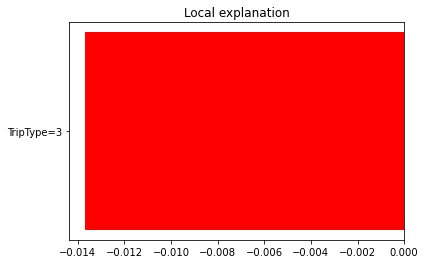

In [31]:
import time
import lime
import lime.lime_tabular
train = train.astype('object')

explainer = lime.lime_tabular.LimeTabularExplainer(train.values,
                                                   feature_names=['TripType'],
                                                   class_names=['price'], 
                                                   categorical_features=[0], 
                                                   verbose=True, mode='regression')
t1 = time.time()
exp = explainer.explain_instance(train.iloc[2], 
     ty,num_features=1,num_samples=100)
print(exp.as_pyplot_figure())
t2 = time.time()
print(t2-t1)

In [36]:
import shap

In [37]:
help(shap)

Help on package shap:

NAME
    shap - # flake8: noqa

PACKAGE CONTENTS
    _cext
    _explanation
    _serializable
    actions (package)
    benchmark (package)
    datasets
    explainers (package)
    links
    maskers (package)
    models (package)
    plots (package)
    utils (package)

SUBMODULES
    other

FUNCTIONS
    unsupported(*args, **kwargs)
        # plotting (only loaded if matplotlib is present)

DATA
    have_matplotlib = True

VERSION
    0.39.0

FILE
    /home/jinfeng/anaconda3/lib/python3.8/site-packages/shap/__init__.py


